In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

In [2]:
full_train = pd.read_csv("train.csv", index_col="id")

y = full_train["Listening_Time_minutes"]
X = full_train.drop("Listening_Time_minutes", axis = 1)

In [3]:
full_train

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
...,...,...,...,...,...,...,...,...,...,...,...
749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.87058
749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.46242
749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.26000


In [4]:
y.describe()

count    750000.000000
mean         45.437406
std          27.138306
min           0.000000
25%          23.178350
50%          43.379460
75%          64.811580
max         119.970000
Name: Listening_Time_minutes, dtype: float64

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

In [6]:
X_train.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
id,,,,,,,,,,
58797,Fitness First,Episode 8,67.60,Health,60.32,Monday,Night,NaN,1.0,Negative
350030,Humor Hub,Episode 68,34.00,Comedy,58.71,Tuesday,Morning,47.74,3.0,Negative
714763,Sports Weekly,Episode 92,45.15,Sports,29.48,Saturday,Evening,NaN,3.0,Positive
251121,True Crime Stories,Episode 24,83.70,True Crime,63.86,Saturday,Evening,NaN,3.0,Negative
428721,Lifestyle Lounge,Episode 4,99.32,Lifestyle,25.77,Friday,Morning,28.01,0.0,Neutral


Podcast_Name                      48
Episode_Title                    100
Episode_Length_minutes         12141
Genre                             10
Host_Popularity_percentage      8031
Publication_Day                    7
Publication_Time                   4
Guest_Popularity_percentage    10010
Number_of_Ads                     10
Episode_Sentiment                  3
dtype: int64


<AxesSubplot:title={'center':'Number of unique data values'}>

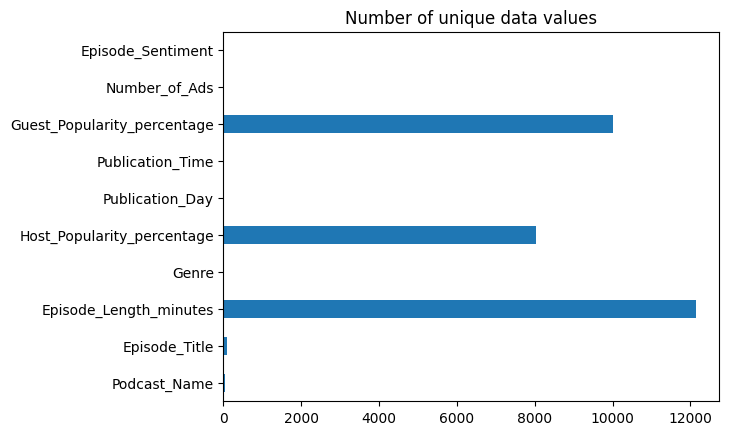

In [7]:
print(X_train.nunique())
X_train.nunique().plot(kind="barh", title = "Number of unique data values")

Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes          69676
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    116866
Number_of_Ads                       1
Episode_Sentiment                   0
dtype: int64


<AxesSubplot:title={'center':'Number of missing data values'}>

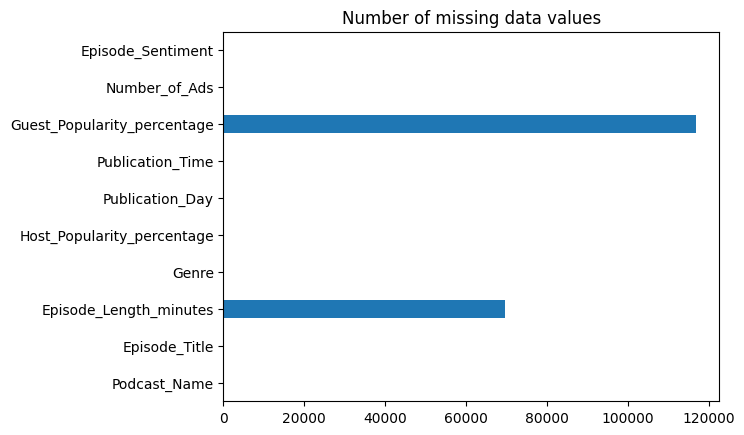

In [8]:
print(X_train.isnull().sum())
X_train.isnull().sum().plot(kind = "barh", title = "Number of missing data values")

In [23]:
# Getting numerical features
num_features = [col for col in X_train.columns if X_train[col].dtype == "float64"]
num_features

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads']

In [24]:
all_num_features = num_features + ["Listening_Time_minutes"]
all_num_features

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'Listening_Time_minutes']

In [15]:
print(all_num_features)

None


In [11]:
# Setting object types in training dataset to category types for xgboost
cat_features = [col for col in X_train.columns if X_train[col].dtype == "object"]
cat_features 
for cat_feat in cat_features:
    X_train[cat_feat] = X_train[cat_feat].astype("category")
    #print(X_train[cat_feat].dtype)


In [12]:
# Setting object types in validation dataset to category types for xgboost
cat_features = [col for col in X_val.columns if X_val[col].dtype == "object"]

for cat_feat in cat_features:    
    X_val[cat_feat] = X_val[cat_feat].astype("category")
#print(X_val.dtypes)

In [13]:
cat_features

['Podcast_Name',
 'Episode_Title',
 'Genre',
 'Publication_Day',
 'Publication_Time',
 'Episode_Sentiment']

In [29]:
data = full_train.copy()
label_encoder = LabelEncoder()

for cat_feat in cat_features:
    data[cat_feat] = label_encoder.fit_transform(data[cat_feat])

In [30]:
data.head()

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
id,,,,,,,,,,,
0,34,98,NaN,9,74.81,4,3,NaN,0.0,2,31.41998
1,24,19,119.80,1,66.95,2,0,75.95,2.0,0,88.01241
2,40,8,73.90,2,69.97,5,1,8.97,0.0,0,44.92531
3,10,40,67.17,8,57.22,1,2,78.70,2.0,2,46.27824
4,31,85,110.51,3,80.07,1,0,58.68,3.0,1,75.61031


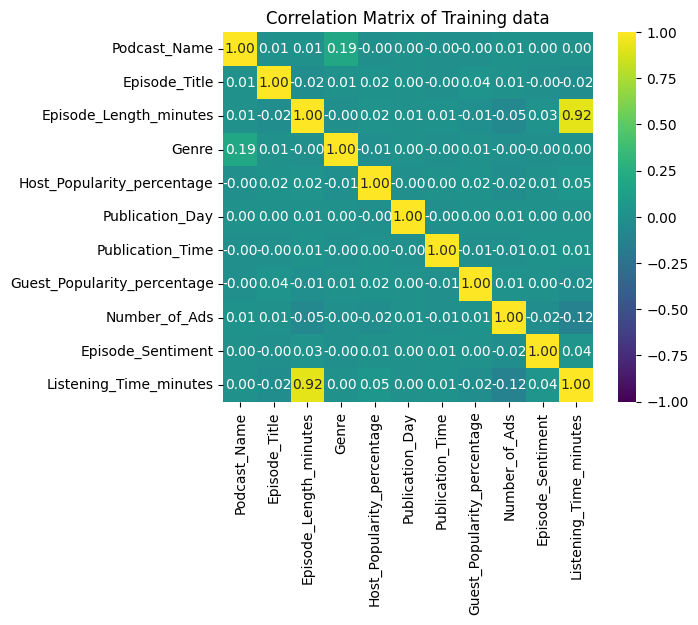

In [32]:
correlation_matrix = data.corr()
heatmap = sns.heatmap(correlation_matrix, 
                      annot = True,
                      vmin = -1,
                      vmax = 1,
                      center = 0,
                      cmap = "viridis",
                      fmt = ".2f",
                      square = True)
plt.title("Correlation Matrix of Training data")
plt.show()

In [ ]:
model = XGBRegressor(enable_categorical = True)
model.fit(X_train, y_train)
preds = model.predict(X_val)

RMSE =  root_mean_squared_error(y_val, preds)
RMSE

13.088236576209288

In [ ]:
# first try, no cat or num imputing: 13.088236576209288